# Open AI Automation Wrapper

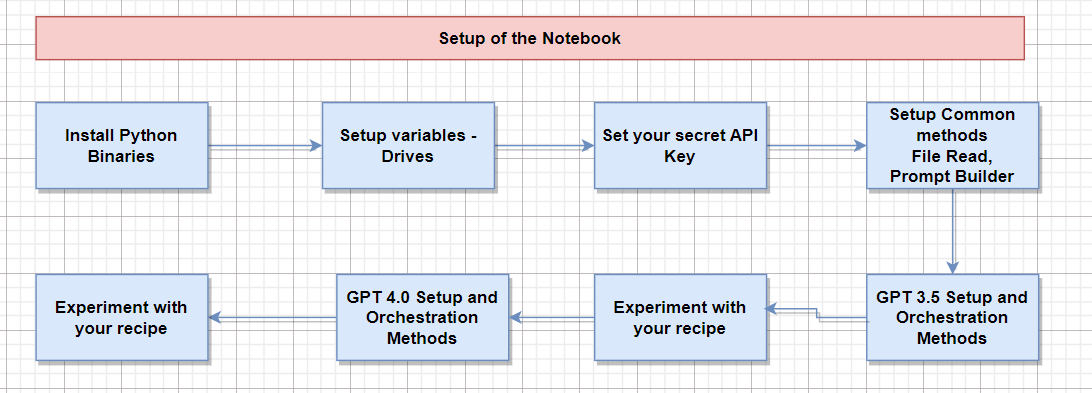

#### Install Open AI Binaries
#### Install Langchain on top of OpenAI
#### Install Backoff and Tenacity
#### Install PDF readers binaries.

In [1]:
!pip install --upgrade openai
#For Fine tuning. Work is pending.
#!pip install --upgrade openai wandb
#Add Langchain
!pip install langchain
!pip install azure-identity azure-keyvault-secrets
!pip install mermaid-python

#These are used only for reading from documents like PDF, etc.
!pip install pypdf
!pip install langchain[llms]
!pip install langchain[all]

from mermaid import Mermaid
import openai
import os
import json
import pprint

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.2/161.2 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.6/348.6 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.4/192.4 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the pack

## Selecting required binaries.

In [2]:
#Langchain
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser

#Building Memory
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory
from google.colab import drive

## Langchain and PDF reading.

In [3]:
from langchain.vectorstores import FAISS
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.document_loaders import PyPDFLoader

In [4]:
from IPython.display import Markdown

In [5]:
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)  # for exponential backoff

#Common Variables

### Common Variables - Path for drives.

In [45]:
##Set this variable for your inputs.
drive_path1 = '/gdrive/MyDrive/Gen-AI/Input'
local_path = '/content'

#### Variable to hold model answer

In [7]:
#holds responses from the model
response_list = []
prompts = []
api_key=""

In [2]:
def read_api_key():
  print("reading key file.")
  #Setup key in Key-Vault or in secure settings.
  #For colab we are reading from temporary google drive storage.
  #api_key =

Secrets Setting - Replace the secret Variable

In [8]:
#This can be read from a secrets location like Azure Keyvault or it can be read from app secrets in case of an Azure Function type application.
openai.api_key  = ''
os.environ["OPENAI_API_KEY"] = openai.api_key

## Common Methods Setup

### Setup google drive

In [9]:
#Mounting Google drive. You can add your favourite drive/storage option.
def mount_google_drive():
  # Mount Google Drive
  drive.mount('/gdrive', force_remount=True)
  print("Drive Path:" + drive_path1)
#Attempt loading google drive
mount_google_drive()

Mounted at /gdrive
Drive Path:/gdrive/MyDrive/Gen-AI/Input


In [10]:
#print files in the drive for test!!
!ls {drive_path1}

BackUp	 GCSE_Year11.json	  PDF_Requirements
Code-C#  GCSE_Year11_Recipe.json  Recipe


### Building Prompt template

In [11]:
# Pass on a role, context and action needed from the model.
# Roles sets the thinking hat model neeeds to put on.
# Context gives it information to be used for the current problem domain.
# Prompt - is the action you want model to take on the problem domain.
def make_prompt(role_for_model, context_for_model, prompt):
  prompt1 = f"""
  ```Think like a/an {role_for_model} and and be as accurate as possible. {cont#ext_for_model} and {prompt} ```
  """
  print(prompt1)
  return prompt1

### GPT 3.5 Model

In [12]:
# list models
models = openai.Model.list()

# print the first model's id
print(models.data[0].id)

# create a chat completion
chat_completion = openai.ChatCompletion.create(model="gpt-3.5-turbo", messages=[{"role": "user", "content": "Hello world"}])

# print the chat completion
print(chat_completion.choices[0].message.content)

text-search-babbage-doc-001
Hello there! How can I assist you today?


### Adding tenacity with retry whenwe hit rate limiting from OpenAI
https://cookbook.openai.com/examples/how_to_handle_rate_limits

### Setting up GPT Model 3.5 for calls. This is the usual one available via ChatGPT interface. Use this when possible as it is cheaper and gives good solution.

In [13]:
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)  # for exponential backoff

prompts = []

## Method with retry
@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def get_response_from_model_3_5(prompt, model="gpt-3.5-turbo"):
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0.0, # this is the degree of randomness of the model's output
    )
    #print(response.choices[0].message["content"])
    return response.choices[0].message["content"]

### Setting up GPT Model 4 for calls. This is only available as paid option for anyone and is atleast 30 times more costly for same type of prompt.

In [14]:
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)  # for exponential backoff


## Method with retry to handle rate limitting
@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def get_response_from_model_4_0(prompt, model="gpt-4"):
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0.0, # this is the degree of randomness of the model's output
    )
    print(response.choices[0].message["content"])
    return response.choices[0].message["content"]

get_response_from_model_4_0("Hello")

Hello! How can I assist you today?


'Hello! How can I assist you today?'

### Read input recipe

In [15]:
import json
def read_input_recepie(path):
  print("read_input_recepie processing ")
  json_data = ""
  mount_google_drive()
  print(path)
  # Open and read the JSON file
  if os.path.isfile(path):
    with open(path, 'r') as json_file:
      #print(json_file)
      json_data = json.load(json_file)
      json_string = json.dumps(json_data)

  #You can access and work with the data as needed. For example, you can print the content:
  print("read_input_recepie processing finished:-\n" + json.dumps(json_data))
  #print(type (json.dumps(json_data)))
  print(type(json.dumps(json_data)))
  return json.dumps(json_data)

In [16]:
def is_valid_json(text):
    try:
        json.loads(text)
        return True
    except json.JSONDecodeError:
        return False

print(is_valid_json("sdfsdfsdfsdf"))

#Test code.
ans = read_input_recepie("/gdrive/MyDrive/Gen-AI/Input/Recipe/InfraArchitect_recipe.json")
print(is_valid_json(ans))

False
read_input_recepie processing 
Mounted at /gdrive
Drive Path:/gdrive/MyDrive/Gen-AI/Input
/gdrive/MyDrive/Gen-AI/Input/Recipe/InfraArchitect_recipe.json
read_input_recepie processing finished:-
{"Role": "Cloud Infrastructure Architect", "Context": "In the context of a software integration project, two distinct systems play crucial roles: SAP and Commercetools SAAS. SAP, as the source system, is responsible for generating files, each of which may contain multiple records. Commercetools, on the other hand, is purpose-built to accept messages via its C# SDK.The project's primary objective is to leverage an Azure-based cloud platform, with a strong emphasis on Platform-as-a-Service (PaaS) solutions. This comprehensive approach encompasses essential components such as Azure API Management, Azure Storage for data storage, Azure Service Bus to ensure reliable messaging, Azure Function Apps for serverless computing, and Azure Logic Apps for seamless workflow orchestration.It's noteworthy

In [17]:
#General method to read a file
def read_file(path):
  mount_google_drive()

  if os.path.isfile(path):
    with open(path, 'r') as file:
     file_data = file.read()
    return file_data

In [ ]:
#Test call.
pprint.pprint(read_file('/gdrive/MyDrive/Gen-AI/Input/Recipe/Person.json'), width=90)

### Iterate the files.

In [ ]:
mount_google_drive()

#Get all the files in a folder.
def iterate_files_content():
  all_items = os.listdir(drive_path1)

  for file_name in all_items:
    file_path = os.path.join(drive_path1,file_name )
    #print(file_path)
    pprint.pprint(read_file(file_path), width=90)
    #print(file_name)

  #Filter only the files (exclude directories)
  #files = [item for item in all_items if os.path.isfile(os.path.join(drive_path1, item))]
  #Iterate through the files
  #for file_name in files:
    #print(file_name)

#Checking files present.
iterate_files_content()

## Parse the output JSON from Open AI

In [ ]:
#Parse a JSON
def parse_json(json_string):
    print("parse_json processing")
    print(type(json_string))
    try:
        # Parse the JSON string into a Python object (usually a dictionary or list)
        parsed_data = json.loads(json_string)
        return parsed_data
    except json.JSONDecodeError as e:
        # Handle JSON decoding errors, such as invalid JSON syntax
        print(f"JSON parsing error: {e}")
        return None

# Example Method Test Case
json_string = '{"name": "John", "age": 30, "city": "New York"}'
parsed_data = parse_json(json_string)
if parsed_data:
    #Access and work with the parsed data
    #print(parsed_data[0].name)
    print(parsed_data.get("name"))

In [ ]:
ans = read_input_recepie("/gdrive/MyDrive/Gen-AI/Input/Recipe/InfraArchitect_recipe.json")
parsed_ans = parse_json(ans)
#print(is_valid_json(parsed_ans))

## Reading Recipe/es one by one depending on the function.

## Debug method to calculate if prompt may be hitting token(context) ceilings for the model.

In [23]:
#Checks the length of the constructed promot lenght. Input should be within Model context limits.
def count_words(input_string):
    #print(input_string)
    #print(type(input_string))
    words = input_string.split()
    word_count = len(words)
    #if word_count > 850:
      #print(input_string)
      #print("Inaccurate or incomplete response is expected as we may be breaching token limit")
    return len(words)

## Emit Model Optput for local debugging.

In [24]:
import markdown
from IPython.display import HTML

#Common method to emit the model responses.
def emit_output(response_list):
  for item in response_list:
    print(item)
    #pprint.pprint(item, width=180)
    #print(markdown.markdown(item))
    #HTML(markdown.markdown(item))
    #html_text = markdown.markdown(item)
    # Display the HTML
    #HTML(html_text)
emit_output(response_list)

Setting the role for the model

In [ ]:
#Common method to build recipe path, reads role, context and prompts.
def build_recipe_path( recipe_filename, basepath):
  print("recipe_filename:-" + recipe_filename)
  print("Basepath:-" + basepath)

  print("Joining path")
  path = os.path.join(basepath, recipe_filename)
  print("Path:- "+path)
  data = parse_json(read_input_recepie(path))

  role_for_model = data["Role"]
  context_for_model = data["Context"]
  prompts = data["Prompts"]
  return  role_for_model, context_for_model, prompts

#test the logic:
build_recipe_path("Recipe/InfraArchitect_recipe.json", drive_path1 )

#/gdrive/MyDrive/Gen-AI/Input/Recipe/Infra_Architect_recipe.json

In [28]:
#Read files in a folder
#def read_files(path):

## Setting up Orchestration Methods on top of OpenAIs GPT 3.5 turbo

### Orchestration Methods
#### GPT 3.5

In [29]:
#Get the recipe file and invoke the model for prompt processing.
def build_and_act_3_5(recipe_filename, basepath=drive_path1, directory="Input", ):
  print(recipe_filename)
  print(basepath)
  print(directory)
  role_for_model, context_for_model, prompts = build_recipe_path(recipe_filename,basepath)
  act_on_prompts_3_5(role_for_model, context_for_model, prompts)

### Action method - invokes the model

In [30]:
def act_on_prompts_3_5(role_for_model, context_for_model, prompts):
    print(prompts)
    for item in prompts:
      print(item)
      #build individual prompts
      #count_words(make_prompt(role_for_model, context_for_model, item))
      response_list.append(get_response_from_model_3_5(make_prompt(role_for_model, context_for_model, item)))

## Test the recipe.
#### Recipe file format - JSON
#### Structure of Recipe:

{
	"Role": "Role_I_Want_Model_To_Pretend",
	"Context": "Context information for the model, wriiten in clear natural language",
	"Prompts": [
		"Instructions for the model_1",
		"Instructions for the model_2"
	]
}

Copy paste above to a text file, name it appropriately and put it on a Google drive/other storage.

In [ ]:
build_and_act_3_5("Recipe/InfraArchitect_recipe.json")

In [ ]:
emit_output(response_list)

## Setting-up Orchestration methods to call GPT Model 4



### Orchestration Method.
#### GPT 4.0

In [33]:
#build the the prompts and invoke them.
def build_and_act_4_0(recipe_filename, basepath=drive_path1, directory="Input" ):
  print(recipe_filename)
  print(basepath)
  print(directory)
  role_for_model, context_for_model, prompts = build_recipe_path(recipe_filename,basepath)
  act_on_prompts_4_0(role_for_model, context_for_model, prompts)

### Invoke the prompts and collect response.

In [34]:
#Invoke the model
def act_on_prompts_4_0(role_for_model, context_for_model, prompts):
    #print(prompts)
    for item in prompts:
      print(item)
      #build individual prompts
      #Makes the promot, calls the model, appends the response to a list variable.
      response_list.append(get_response_from_model_4_0(make_prompt(role_for_model, context_for_model, item)))

### Testing Model 4 with same recipes

In [ ]:
#build_and_act_4_0("Recipe/Business_Analyst_recipe.json")
#build_and_act_4_0("GCSE_Year11.json")
#build_and_act_4_0("GCSE_Year11_Recipe.json")
#build_recipe_path(drive_path1, "Input", "Infra_Architect_recipe.json")
build_and_act_4_0("Recipe/InfraArchitect_recipe.json")

In [ ]:
emit_output(response_list)

In [ ]:
build_and_act_4_0("Recipe/Cloud_AppDeveloper_Recepie.json")

In [ ]:
emit_output(response_list)

In [ ]:
build_and_act_4_0("Recipe/BA_Recepie.json")

In [ ]:
emit_output(response_list)

#Following are some rapid experiment
#### You can create your own logic and plug them to the notebook above

In [ ]:
#Read the PDF file to get the specs using langchain
#loader = PyPDFLoader("PITLDNCC.pdf")
#pages = loader.load_and_split()

In [ ]:
#Getting page content
data = pages
pages = pages.count
print(pages)
print(data)

In [ ]:
print(documents.count)

#for index, item in enumerate(documents):
    #print(f"Index {index}: {item}")
   # print("index - " + index)
    #print(count_words(documents[index].page_content))
#act_on_prompts_4_0("C# Application Developer",documents[0].page_content,"Generate C# code for every statement which matches requirement in this context. Keep seperate for method and follow best practices.")
get_response_from_model_4_0(make_prompt("C# Application Developer", documents[0].page_content, "Generate C# code for every requirement in this context. Use latest dotnet template and utilise BackgroundService. Keep seperate method for every requirement, add code comments and follow best practices."))

In [ ]:
type(data)

In [ ]:
for item in data:
    print(item)
    regex = "(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s"
    print(type(item))


    #response = re.split(regex, item)

In [ ]:
for index, item in enumerate(data):
    print(f"Index {index}: {item}")

In [ ]:

import regex as re
regex = "(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s"
re.split(regex, data)

In [ ]:
data = {
    "name": "John",
    "age": 30,
    "city": "New York",
    "pets": [
        {"type": "dog", "name": "Fido"},
        {"type": "cat", "name": "Fluffy"}
    ]
}

pprint.pprint(data, width=20)

In [ ]:
from IPython.display import Markdown

# Markdown text
markdown_text = """
# Heading 1
## Heading 2

**Bold Text** or __Bold Text__
*Italic Text* or _Italic Text_

- Bullet Point 1
- Bullet Point 2

[Link to Google](https://www.google.com/)

![Image Alt Text](image_url.jpg)
"""

# Render the Markdown text
Markdown(markdown_text)

In [ ]:
import markdown
from IPython.display import HTML

# Your Markdown text
markdown_text = """
# Heading 1

This is a **bold** and *italic* text.

- Item 1
- Item 2
- Item 3

A [link](https://www.example.com).
"""

# Convert Markdown to HTML
html_text = markdown.markdown(markdown_text)

# Display the HTML
HTML(html_text)


In [ ]:
!pip install markdown
import markdown

# Your input text
input_text = """
# Heading 1
This is a **bold** and *italic* text.1
- Item 1
- Item 2
- Item 3
A [link](https://www.example.com).
"""

# Convert to Markdown
markdown_text = markdown.markdown(input_text)
#html_text = markdown.markdown(markdown_text)

# Display the HTML
HTML(markdown_text)
# Print the Markdown
#print(markdown_text)